# 1. Membership Inference Attack (MIA)
对 （Split learning 或 VFL 框架下的）神经网络模型进行membership infernece attack，目前采用了4个攻击方法
* Modified Entropy (Mentropy)
* Entropy
* Confidence
* Correctness

In [1]:
# 导包
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import math
import sys
import urllib
import pickle
import argparse

sys.path.append('/home/dengruijun/data/FinTech/PP-Split/')
from ppsplit.attacks.membership_inference.Mentr_attack import MentrAttack # 包含了4种方法的攻击类
from target_model.models.splitnn_utils import split_weights_client
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# 设置一些超参数
batch_size = 100 # 批大小
# unit_net_route = '/home/dengruijun/data/FinTech/PP-Split/results/trained_models/Purchase100/Purchase_bestmodel_param.pth' # 待检测模型
unit_net_route = '/home/dengruijun/data/FinTech/VFL/MIAs/membership_inference_evaluation/adv_reg/training_code/models/purchase_undefended/model_best.pth.tar' # 待检测模型
split_layer = 8 # 切隔层

In [3]:
# purchase 数据集 和 模型 导入
from target_model.models.PurchaseNet import PurchaseClassifier1, purchase_cfg
    
class PurchaseClassifier(nn.Module):
    def __init__(self,num_classes=100):
        super(PurchaseClassifier, self).__init__()

        self.features = nn.Sequential(
            nn.Linear(600,1024),
            nn.Tanh(),
            nn.Linear(1024,512),
            nn.Tanh(),
            nn.Linear(512,256),
            nn.Tanh(),
            nn.Linear(256,128),
            nn.Tanh(),
        )
        self.classifier = nn.Linear(128,num_classes)
        
    def forward(self,x):
        hidden_out = self.features(x)
        return hidden_out

from target_model.data_preprocessing.preprocess_purchase import preprocess_purchase_shadow
class_num = 100 # Purchase的分类类别数目

# 模型加载并切割：
# client_net = PurchaseClassifier1(layer=split_layer)
# pweights = torch.load(unit_net_route,map_location=device)
# if split_layer < len(purchase_cfg):
#     pweights = split_weights_client(pweights,client_net.state_dict())
# client_net.load_state_dict(pweights)

client_net = PurchaseClassifier(num_classes=100)
client_net = torch.nn.DataParallel(client_net).cuda()
checkpoint = torch.load(unit_net_route)
client_net.load_state_dict(checkpoint['state_dict'])
client_net.eval()

# model = PurchaseClassifier1()
# model = torch.nn.DataParallel(model).cuda()
# checkpoint = torch.load(target_model_path)
# model.load_state_dict(checkpoint['state_dict'])
# model.eval()

# 加载数据集
shadow_train_loader, shadow_test_loader, target_train_loader, target_test_loader = preprocess_purchase_shadow(batch_size=batch_size)


datset route: /home/dengruijun/data/FinTech/DATASET/kaggle-dataset/Purchase100//data.npz
Data loading finished


In [4]:
# 攻击 对象实例化
MIA = MentrAttack(num_classes = class_num)

# 攻击初始化，推理模型
# 这里 shadow model 和 target model 用的是相同的一个
MIA.prepare_model_performance(client_net, shadow_train_loader, shadow_test_loader, 
                              client_net, target_train_loader, target_test_loader)


In [5]:
# 实施MIA攻击
# 设定要执行的攻击类型：默认是4种都执行
benchmark_methods = ['correctness','confidence','entropy','modified entropy'] # 可以取子集
MIA.mem_inf_benchmarks(all_methods=True)


For membership inference attack via correctness, the attack acc is 0.500, with train acc 0.000 and test acc 0.000
For membership inference attack via confidence, the attack acc is 0.514
For membership inference attack via entropy, the attack acc is 0.543
For membership inference attack via modified entropy, the attack acc is 0.515


In [6]:
# 实施MIA攻击，只执行指定的2种攻击
benchmark_methods = ['correctness','modified entropy'] # 可以取子集
MIA.mem_inf_benchmarks(all_methods=False, benchmark_methods = benchmark_methods)

For membership inference attack via correctness, the attack acc is 0.500, with train acc 0.000 and test acc 0.000
For membership inference attack via modified entropy, the attack acc is 0.515


# 2. Quantification for MIA
用 privacy score 量化 MIA攻击隐私情况

数据共有100个类别
target model 的 训练数据 (共9866）的MIA隐私泄漏 privacy score 为： [0.50675702 0.54753873 0.50663025 ... 0.50575609 0.53858265 0.52959628]
平均privacy score为0.5095770072981051


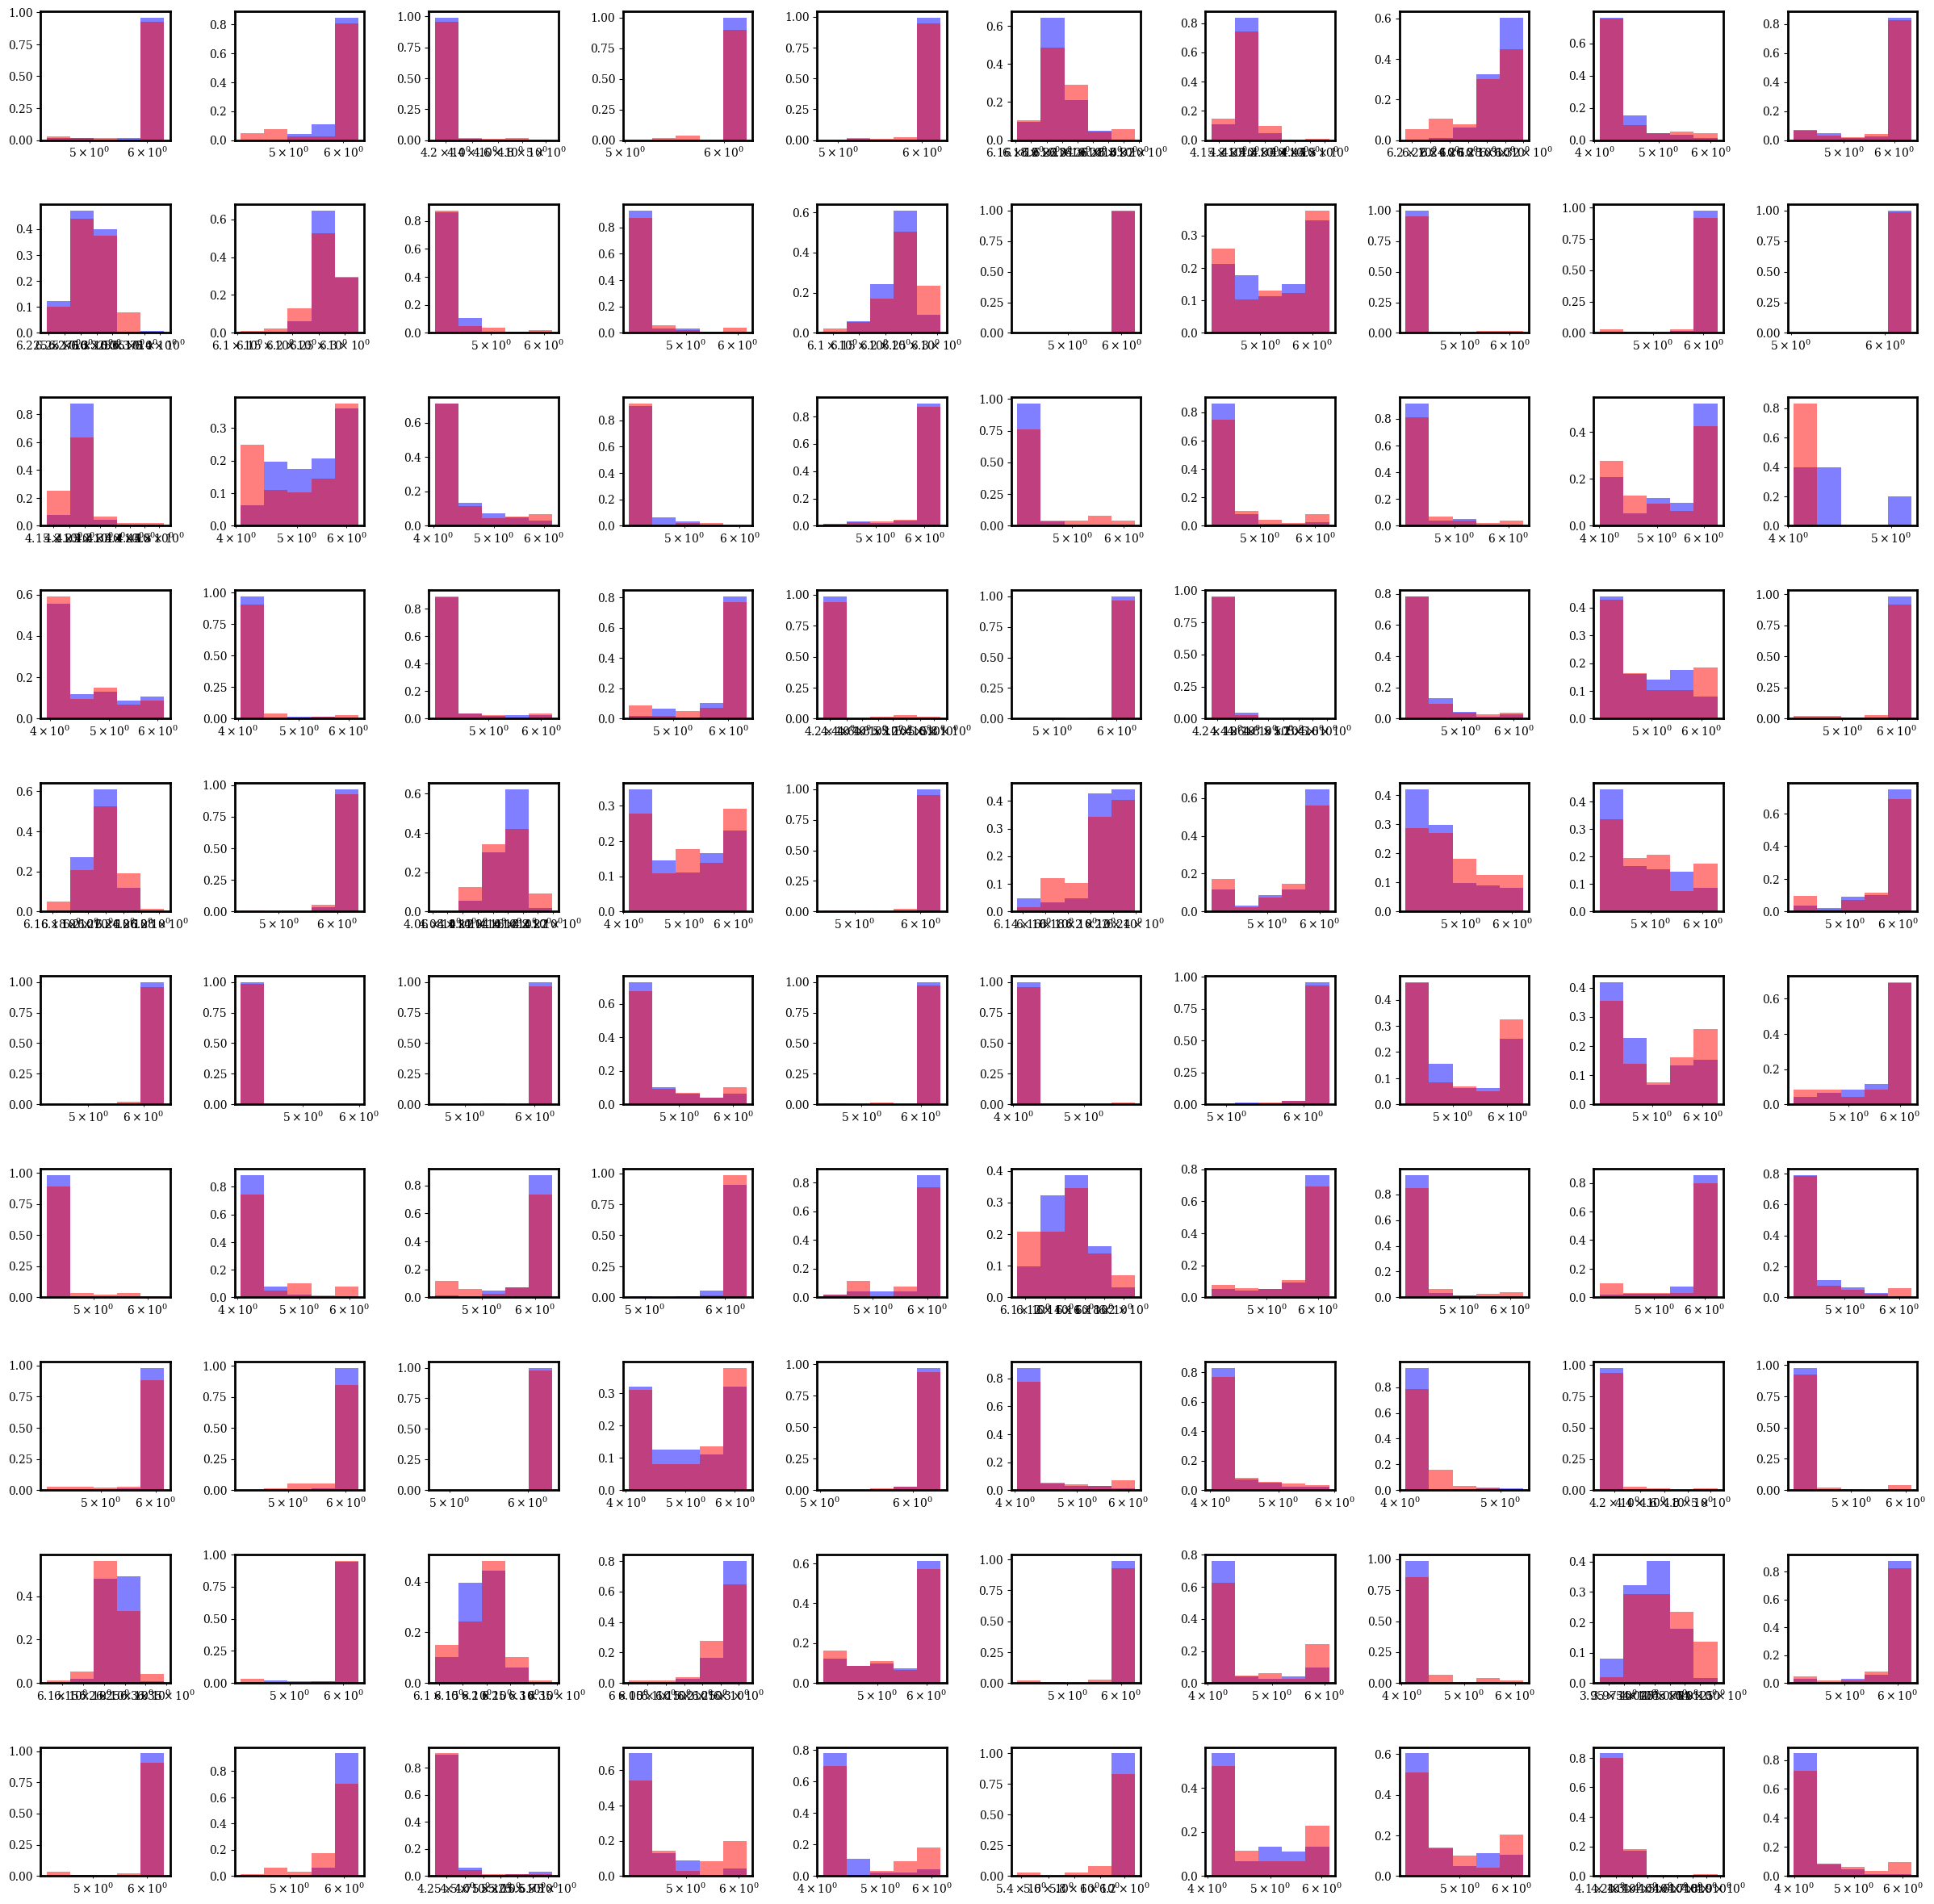

In [7]:
from ppsplit.quantification.privacy_risk_score.privacy_risk_score import calculate_risk_score # 导包
# private risk score calculation
risk_score = calculate_risk_score(MIA.s_tr_m_entr, MIA.s_te_m_entr,  # shadow model mentropy
                                MIA.s_tr_labels, MIA.s_te_labels,  # shadow model labels
                                MIA.t_tr_m_entr, MIA.t_tr_labels) # target model mentropy & labels
print(f"target model 的 训练数据 (共{len(risk_score)}）的MIA隐私泄漏 privacy score 为：", risk_score)
print(f"平均privacy score为{risk_score.mean()}")